In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import seaborn as sns

# Connect to SQLite3

In [2]:
import sqlite3
conn = sqlite3.connect('AI_SCOUT.db')
pd.read_sql('SELECT * FROM RAPTOR', conn)

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,...,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,...,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,...,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,...,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,...,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,...,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20054,weissbo01,Bob Weiss,1977,34,PG,WSB,1.0,WAS,62,768,...,3.1,0.5,99.5,11.5,97.9,46.6,NaN,78.4,0.0,27.8
20055,riordmi01,Mike Riordan,1977,31,SF,WSB,1.0,WAS,49,289,...,0.5,0.4,81.1,15.4,103.3,36.2,NaN,73.3,0.0,16.0
20056,weathni01,Nick Weatherspoon,1977,26,SF,WSB,1.0,WAS,11,152,...,0.9,1.7,78.3,21.1,100.9,35.5,NaN,62.5,0.0,10.5
20057,pacejo01,Joe Pace,1977,23,C,WSB,1.0,WAS,30,119,...,0.8,7.3,88.2,27.3,94.3,43.6,NaN,55.2,0.0,52.7


In [3]:
pd.read_sql('SELECT * FROM RAPTOR', conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20059 entries, 0 to 20058
Data columns (total 40 columns):
player_id      20059 non-null object
name_common    20059 non-null object
year_id        20059 non-null int64
age            20059 non-null int64
pos            20059 non-null object
team_id        20059 non-null object
tmRtg          20059 non-null float64
franch_id      20059 non-null object
G              20059 non-null int64
Min            20059 non-null int64
MP%            20059 non-null float64
MPG            20059 non-null float64
P/36           20054 non-null float64
TS%            19964 non-null float64
A/36           20054 non-null float64
R/36           20054 non-null float64
SB/36          20054 non-null float64
TO/36          20054 non-null float64
Raptor O       20059 non-null float64
Raptor D       20059 non-null float64
Raptor+/-      20059 non-null float64
Raptor WAR     20059 non-null float64
PIE%           20054 non-null float64
AWS%           20054 non-null 

# Create Training Dataset

In [4]:
# Training Set Data will be data 1980 to 2000
# Test Set will be data 2000 to 2020 Players
# Target Position ['PG', 'SF', 'SG', 'PF', 'C', 'G-F', 'F', 'G']

df_oldNBA = pd.read_sql(
    """
    SELECT * FROM RAPTOR
    WHERE year_id BETWEEN 1990 AND 2000
    AND G > 35;
    """, conn)

In [7]:
pd.set_option('display.max_columns', 100)
df_oldNBA.tail()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
4987,turpime01,Melvin Turpin,1990,29,C,WSB,-2.2,WAS,59,818,20.6,13.9,12.2,57.4,1.2,9.8,2.7,2.0,-2.0,0.3,-1.8,0.4,7.4,8.8,14.3,4.3,15.8,11.5,17.7,14.6,0.9,3.3,112.2,14.8,107.9,53.1,0.0,78.9,1.0,34.0
4988,hammoto01,Tom Hammonds,1990,22,PF,WSB,-2.2,WAS,61,805,20.3,13.2,14.4,47.5,2.3,7.6,1.1,2.1,-3.2,-1.9,-5.1,-1.0,6.1,4.7,19.5,8.5,12.0,8.1,14.5,11.3,0.7,1.0,99.3,19.3,111.2,43.9,0.0,64.3,0.3,33.2
4989,willijo02,John Williams,1990,23,SF,WSB,-2.2,WAS,18,632,15.9,35.1,18.7,52.6,4.8,7.8,1.7,2.5,1.2,0.4,1.7,1.4,13.6,12.7,22.9,18.9,12.1,4.6,18.8,11.6,1.6,0.8,107.4,22.7,108.2,50.0,11.1,77.4,6.6,30.7
4990,rothdo01,Doug Roth,1990,22,C,WSB,-2.2,WAS,42,412,10.4,9.8,7.1,43.9,1.8,10.5,1.8,1.4,-3.9,0.0,-3.9,-0.2,4.7,5.2,10.7,5.9,14.8,11.4,20.1,15.7,0.9,1.8,100.0,11.7,108.1,43.5,0.0,50.0,1.2,16.3
4991,hortoed01,Ed Horton,1990,22,PF,WSB,-2.2,WAS,45,374,9.4,8.3,19.6,52.5,1.8,10.5,1.4,3.8,-1.3,-2.1,-3.4,-0.1,7.2,7.5,25.3,7.3,16.9,16.9,14.2,15.6,1.2,0.8,101.1,25.8,110.3,50.6,0.0,60.9,2.5,42.6


In [8]:
df_oldNBA.describe()

,year_id,age,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
count,4992.000000,4992.000000,4992.00000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4970.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.00000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4958.000000,4033.000000,4778.000000,4963.000000,4963.000000
mean,1995.180889,27.234976,-0.23768,49.250000,1173.816106,30.749479,20.067448,14.458514,50.259940,3.303906,6.766727,2.116887,2.537400,-1.592408,-0.447656,-2.041426,1.64355,7.780369,7.272216,19.249559,13.409375,15.185337,6.655769,13.425561,10.036959,1.739303,1.445353,101.456130,19.246374,106.798758,45.512666,24.707736,71.816450,13.514185,33.863268
std,3.140268,3.940638,5.35161,27.327727,959.936447,24.690666,10.795172,5.556451,9.779262,2.506576,3.655953,1.383702,1.596829,4.154268,2.062242,5.118834,3.12517,5.385447,7.662980,6.110061,10.291519,7.032511,5.486185,7.360402,5.397044,1.145989,2.149260,18.524111,5.881230,5.010153,10.435388,18.371247,14.452579,16.532818,23.575109
min,1990.000000,18.000000,-15.20000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-82.200000,-20.900000,-103.100000,-5.40000,-68.600000,-150.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.300000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1992.000000,24.000000,-4.22500,25.000000,282.000000,7.575000,10.900000,11.200000,47.200000,1.500000,4.000000,1.400000,1.800000,-3.300000,-1.500000,-4.000000,-0.20000,5.600000,4.700000,15.600000,6.200000,11.500000,2.900000,8.400000,5.900000,1.100000,0.300000,96.300000,15.900000,103.900000,42.300000,7.700000,65.500000,0.500000,21.700000
50%,1995.000000,27.000000,0.60000,52.000000,986.500000,25.950000,19.200000,14.300000,51.550000,2.600000,6.200000,2.000000,2.400000,-1.200000,-0.500000,-1.700000,0.30000,8.100000,8.000000,18.900000,10.700000,14.300000,5.900000,12.400000,9.300000,1.600000,0.900000,103.900000,18.900000,107.100000,46.600000,28.600000,73.900000,5.400000,30.800000
75%,1998.000000,30.000000,3.60000,76.000000,1931.000000,51.300000,29.400000,17.500000,55.100000,4.400000,9.200000,2.600000,3.000000,0.600000,0.600000,0.600000,2.50000,10.500000,11.000000,22.400000,18.300000,17.800000,9.400000,17.900000,13.600000,2.200000,1.900000,110.200000,22.100000,110.125000,50.100000,36.200000,80.800000,23.550000,41.000000
max,2000.000000,43.000000,13.40000,82.000000,3533.000000,89.300000,44.500000,119.800000,113.600000,26.500000,79.600000,40.800000,39.900000,38.200000,24.800000,37.800000,22.70000,65.200000,70.400000,163.000000,182.300000,100.000000,118.400000,231.800000,114.900000,17.500000,77.800000,250.000000,187.800000,121.300000,100.000000,100.000000,100.000000,100.000000,400.000000


In [14]:
# Dropping player_id, name_common, year_id, team_id, franc_id 
df_oldNBA.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id'], axis=1, inplace=True)
df_oldNBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 35 columns):
age           4992 non-null int64
pos           4992 non-null object
tmRtg         4992 non-null float64
G             4992 non-null int64
Min           4992 non-null int64
MP%           4992 non-null float64
MPG           4992 non-null float64
P/36          4992 non-null float64
TS%           4970 non-null float64
A/36          4992 non-null float64
R/36          4992 non-null float64
SB/36         4992 non-null float64
TO/36         4992 non-null float64
Raptor O      4992 non-null float64
Raptor D      4992 non-null float64
Raptor+/-     4992 non-null float64
Raptor WAR    4992 non-null float64
PIE%          4992 non-null float64
AWS%          4992 non-null float64
USG%          4992 non-null float64
AST%          4992 non-null float64
TOV%          4992 non-null float64
ORB%          4992 non-null float64
DRB%          4992 non-null float64
TRB%          4992 non-null float64


#### Clean Missing Data

In [15]:
df_oldNBA.shape

(4992, 35)

In [11]:
df_oldNBA.isna().sum()

player_id        0
name_common      0
year_id          0
age              0
pos              0
team_id          0
tmRtg            0
franch_id        0
G                0
Min              0
MP%              0
MPG              0
P/36             0
TS%             22
A/36             0
R/36             0
SB/36            0
TO/36            0
Raptor O         0
Raptor D         0
Raptor+/-        0
Raptor WAR       0
PIE%             0
AWS%             0
USG%             0
AST%             0
TOV%             0
ORB%             0
DRB%             0
TRB%             0
STL%             0
BLK%             0
ORtg             0
%Pos             0
DRtg             0
2P%             34
3P%            959
FT%            214
3PAr            29
FTAr            29
dtype: int64

In [16]:
df_oldNBA[df_oldNBA.isna().any(axis=1)]

,age,pos,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,33,C,-5.8,82,2984,75.2,36.4,12.4,62.1,1.4,15.2,3.9,2.3,0.1,1.2,1.3,6.2,14.9,17.3,13.8,5.4,18.7,11.2,31.3,21.2,0.5,5.9,116.1,14.9,100.7,56.2,NaN,70.8,0.0,73.5
24,23,PF,-0.8,55,856,21.7,15.6,18.6,60.2,1.3,16.3,1.1,3.0,2.0,-1.4,0.7,1.5,12.7,14.3,21.0,5.6,16.1,17.8,31.7,24.4,1.2,0.4,116.9,22.1,103.2,52.8,NaN,73.5,0.0,71.3
26,32,C,-0.8,30,269,6.8,9.0,7.5,50.7,1.8,9.5,2.5,1.8,-2.8,0.1,-2.7,0.0,2.6,4.0,10.5,6.9,19.9,11.7,17.0,14.2,1.9,2.2,106.5,11.9,104.0,44.2,NaN,71.4,0.0,48.8
27,23,PG,-0.8,3,41,1.0,13.7,3.7,23.1,4.6,2.8,0.0,2.8,-8.0,-5.1,-13.1,-0.2,-3.5,-8.1,12.3,16.3,25.8,2.6,5.9,4.2,0.0,0.0,59.8,13.5,112.8,16.7,NaN,33.3,0.0,100.0
40,25,C,2.8,41,399,10.1,9.7,12.9,46.1,0.5,10.6,1.6,2.6,-6.0,-0.4,-6.4,-0.7,6.0,4.5,19.4,2.0,15.7,10.4,20.4,15.5,1.2,1.4,89.4,19.2,101.4,41.8,NaN,60.4,0.0,43.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,33,C,5.0,82,2281,57.5,27.8,6.5,56.1,0.6,9.9,3.8,1.2,-3.4,2.9,-0.5,2.6,7.3,9.1,8.2,2.2,17.6,9.4,20.8,15.4,0.7,5.5,111.2,8.7,102.5,52.7,NaN,66.9,0.0,39.3
4973,23,C,5.0,77,764,19.3,9.9,16.2,61.3,0.9,9.4,1.9,3.1,-3.4,0.0,-3.4,-0.2,7.4,5.5,19.0,3.7,18.9,7.9,20.8,14.7,1.0,1.9,106.2,18.3,104.3,56.3,NaN,74.3,0.0,49.1
4976,24,PF,5.0,16,56,1.4,3.5,10.7,27.7,2.7,10.0,0.0,4.0,-9.9,-4.5,-14.4,-0.3,-4.5,-9.8,27.2,10.3,17.2,22.4,9.8,15.7,0.0,0.0,70.4,27.8,111.1,28.6,NaN,0.0,0.0,7.1
4978,26,PG,5.0,1,6,0.2,6.0,12.5,56.8,6.2,0.0,0.0,18.7,-22.7,-11.6,-34.4,-0.1,-23.6,-43.9,34.6,19.8,63.0,0.0,0.0,0.0,0.0,0.0,49.6,39.6,113.4,NaN,NaN,50.0,NaN,NaN


In [18]:
df_oldNBA.dropna(inplace=True)

In [19]:
df_oldNBA.shape

(3959, 35)

# Train, Test Split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Define X and y
X = df_oldNBA.drop(columns=['pos'], axis = 1)
y = df_oldNBA['pos']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [23]:
# Check value counts
print(y_train.value_counts(), '\n\n', y_test.value_counts())

SG    690
PG    679
SF    607
PF    594
C     399
Name: pos, dtype: int64 

 PG    233
SF    213
PF    205
SG    199
C     140
Name: pos, dtype: int64


# Fit Model

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
# Instantiate the model
lr = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
lr.fit(X_train, y_train)

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# Predict

In [28]:
# Generate predictions
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)
y_hat_test_proba = lr.predict_proba(X_test)

# Evaluate

In [31]:
from sklearn.metrics import confusion_matrix

In [33]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print(cnf_matrix)

[[124  15   0   1   0]
 [ 20 146   3  27   9]
 [  0   2 217   2  12]
 [  0  30   5 116  62]
 [  0   6  33  27 133]]


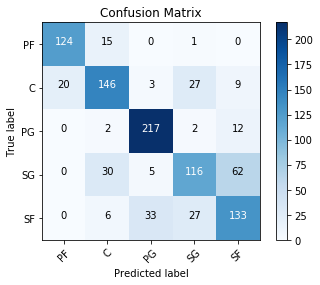

In [34]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y) 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cnf_matrix.max() / 2.  
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

Notes for tuning
- minimum 35 games
- dimensionality reduction
- regularization

In [ ]:
conn.close()